In [76]:
import torch
from markov_chain_monte_carlo import * 
import numpy as np
import matplotlib.pyplot as plt

class LogisticClassifier:
    def __init__(self,samples, labels,mu_beta=None, Sigma_beta=None):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        if mu_beta is not None:
            self.mu_beta = mu_beta
        else:
            self.mu_beta = torch.zeros((self.sample_dim+1)*self.C)
        if Sigma_beta is not None:
            self.Sigma_beta = Sigma_beta
        else: 
            self.Sigma_beta = 5*torch.eye((self.sample_dim+1)*self.C)   
    
    def sample_beta_from_prior(self,num_samples):
        return torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).sample(num_samples)
    
    def log_prob(self,samples, betas):
        log_prob = -torch.cat([samples, torch.ones(samples.shape[0],1)], dim = -1).unsqueeze(0).repeat(betas.shape[0],1,1)@betas.reshape(betas.shape[0],self.sample_dim+1,self.C)
        return log_prob - torch.logsumexp(log_prob, dim = -1, keepdim =True)
        
    def log_posterior_prob(self,betas):
        return torch.sum(self.log_prob(self.samples, betas)*self.labels.unsqueeze(0).repeat(betas.shape[0],1,1),dim = [-2,-1]) + torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).log_prob(betas)

class LogisticClassifierQuadratic:
    def __init__(self,samples, labels,mu_beta=None, Sigma_beta=None):
        self.samples = samples
        self.labels = labels
        self.sample_dim = samples.shape[-1]
        self.C = labels.shape[-1]
        if mu_beta is not None:
            self.mu_beta = mu_beta
        else:
            self.mu_beta = torch.zeros((2*self.sample_dim+1)*self.C)
        if Sigma_beta is not None:
            self.Sigma_beta = Sigma_beta
        else: 
            self.Sigma_beta = 5*torch.eye((2*self.sample_dim+1)*self.C)   
    
    def sample_beta_from_prior(self,num_samples):
        return torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).sample(num_samples)
    
    def log_prob(self,samples, betas):
        log_prob = -torch.cat([torch.square(samples),samples, torch.ones(samples.shape[0],1)], dim = -1).unsqueeze(0).repeat(betas.shape[0],1,1)@betas.reshape(betas.shape[0],2*self.sample_dim+1,self.C)
        return log_prob - torch.logsumexp(log_prob, dim = -1, keepdim =True)
        
    def log_posterior_prob(self,betas):
        return torch.sum(self.log_prob(self.samples, betas)*self.labels.unsqueeze(0).repeat(betas.shape[0],1,1),dim = [-2,-1]) + torch.distributions.MultivariateNormal(self.mu_beta, self.Sigma_beta).log_prob(betas)

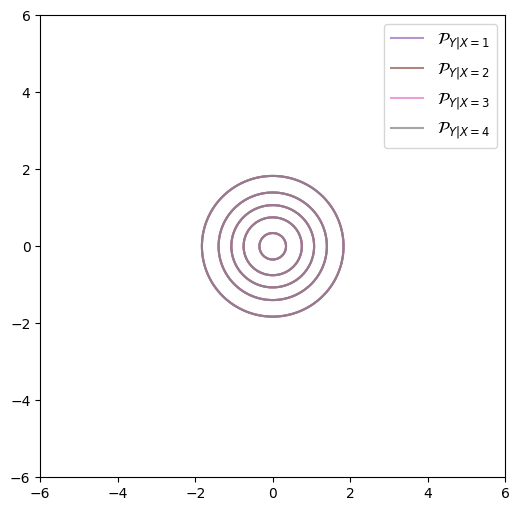

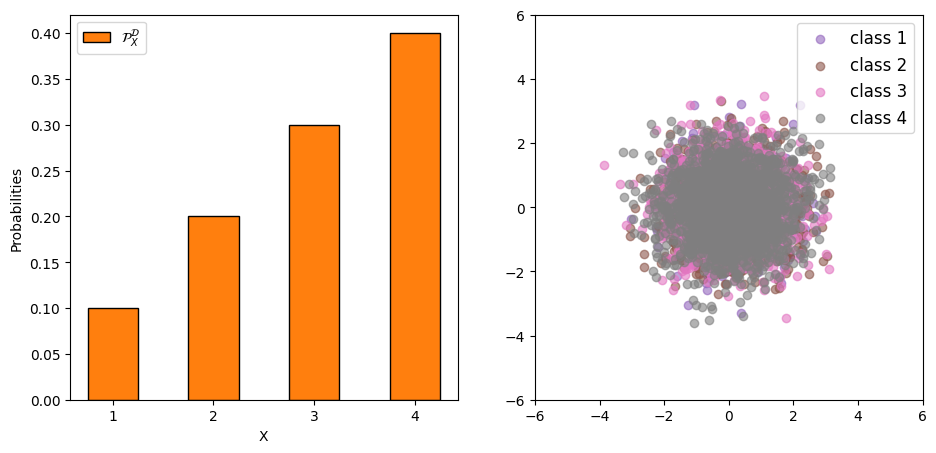

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.44it/s, acceptance = tensor(0.4600)]


torch.Size([4])


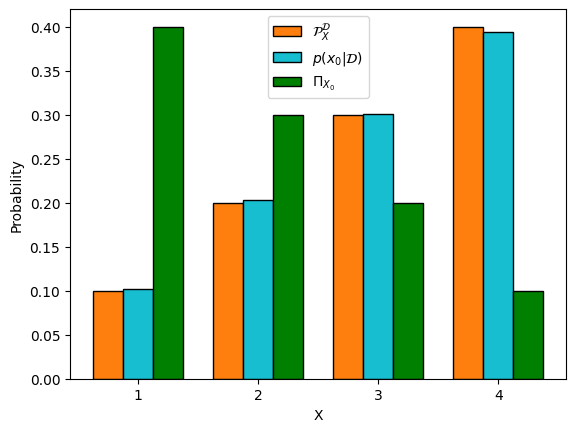

In [48]:
m = 0
inference_prior = torch.tensor([4,3,2,1])/10
r = np.arange(4)
dataset_prior = torch.tensor([1,2,3,4])/10

locations = m*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0])
    obs = torch.sum(mvn.sample(number_samples)*labels.unsqueeze(-1), dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([5000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i+4))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

total_numbers = 5000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1", color='C' +str(4))
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2", color='C' +str(5))
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3", color='C' +str(6))
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4", color='C' +str(7))
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None,100)
samples_beta_post = sampler.sample(200,tau = 6e-4)
with torch.no_grad():
    list_log_prob = torch.mean(torch.exp(model.log_prob(samples_obs,samples_beta_post)), dim =[0,1])

prior_inference = torch.tensor([4,3,2,1])/10

r = np.arange(4) 
width = 0.25

plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'C9', 
        width = width, edgecolor = 'black', 
        label=r'$p(x_0|\mathcal{D})$') 
ax.bar(r+4*width, prior_inference, color = 'green', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 

ax.legend()
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 

plt.show() 

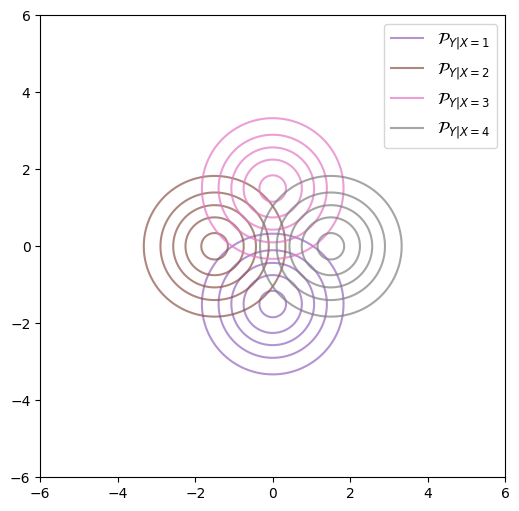

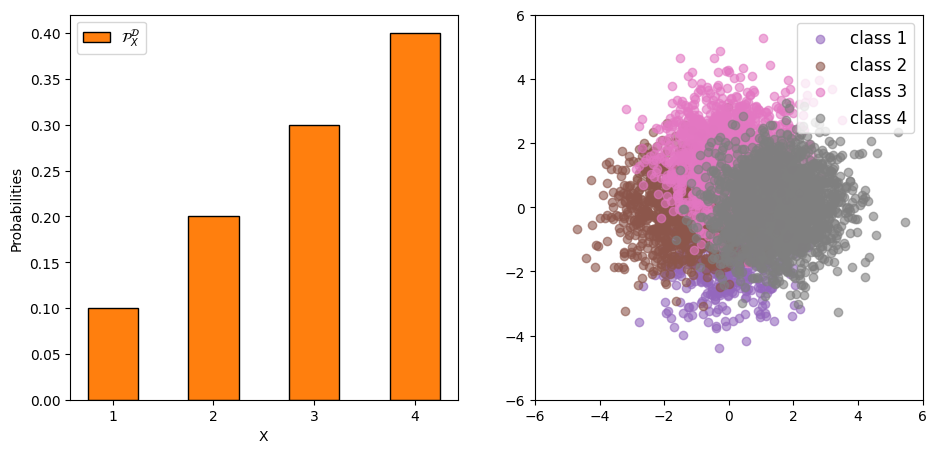

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:36<00:00,  5.18it/s, acceptance = tensor(0.3800)]

torch.Size([4])


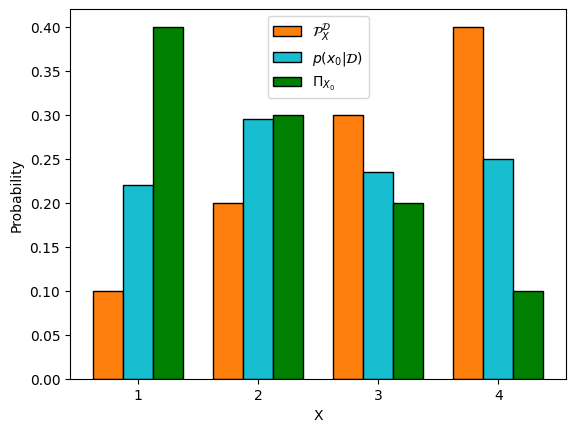

In [75]:
m = 1.5
inference_prior = torch.tensor([4,3,2,1])/10
r = np.arange(4)
dataset_prior = torch.tensor([1,2,3,4])/10

locations = m*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0])
    obs = torch.sum(mvn.sample(number_samples)*labels.unsqueeze(-1), dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([5000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i+4))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

total_numbers = 5000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1", color='C' +str(4))
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2", color='C' +str(5))
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3", color='C' +str(6))
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4", color='C' +str(7))
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None,100)
samples_beta_post = sampler.sample(500,tau = 8e-4)
with torch.no_grad():
    list_log_prob = torch.mean(torch.exp(model.log_prob(samples_obs,samples_beta_post)), dim =[0,1])
print(list_log_prob.shape)

prior_inference = torch.tensor([4,3,2,1])/10


r = np.arange(4) 
width = 0.25

fig = plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'C9', 
        width = width, edgecolor = 'black', 
        label=r'$p(x_0|\mathcal{D})$') 
ax.bar(r+4*width, prior_inference, color = 'green', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 


ax.legend(ncol = 1, fontsize = 16.6)
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 

plt.show() 

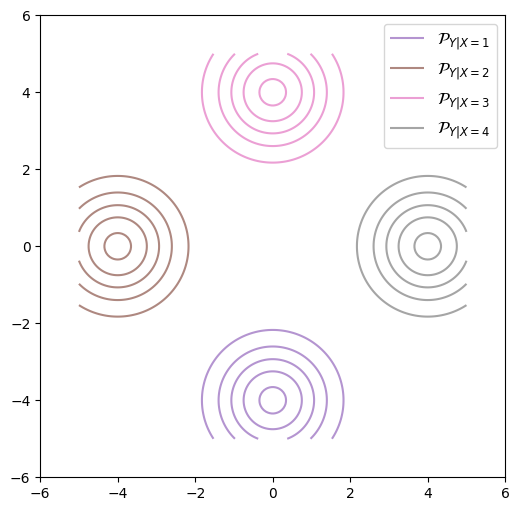

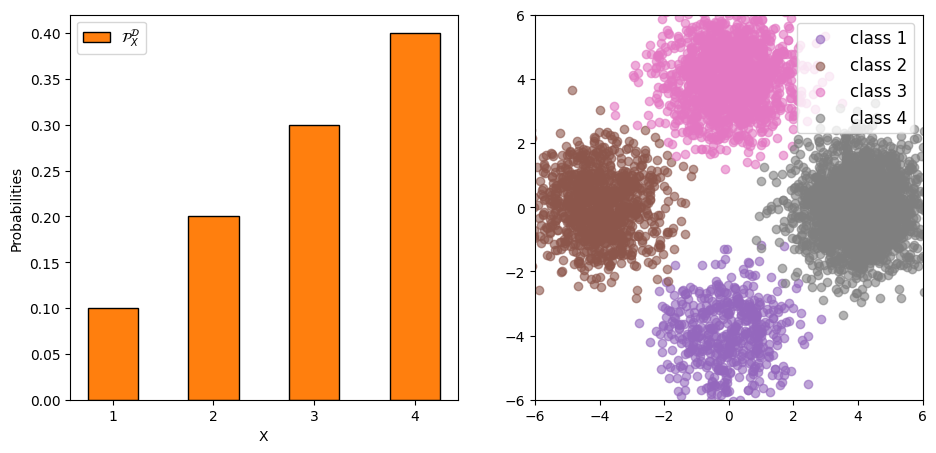

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.44it/s, acceptance = tensor(0.7500)]

torch.Size([4])


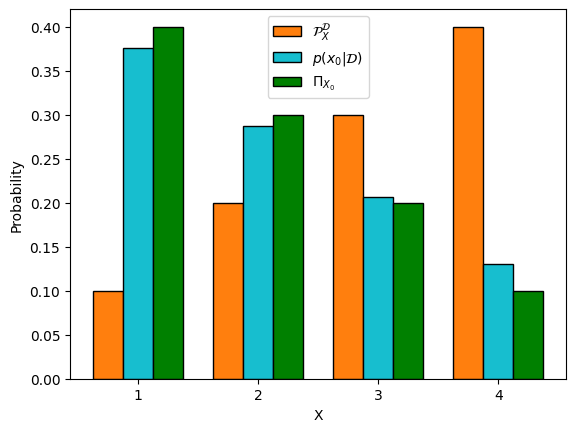

In [65]:
m = 4
inference_prior = torch.tensor([4,3,2,1])/10
r = np.arange(4)
dataset_prior = torch.tensor([1,2,3,4])/10

locations = m*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0])
    obs = torch.sum(mvn.sample(number_samples)*labels.unsqueeze(-1), dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([5000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i+4))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

total_numbers = 5000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1", color='C' +str(4))
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2", color='C' +str(5))
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3", color='C' +str(6))
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4", color='C' +str(7))
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None,100)
samples_beta_post = sampler.sample(500,tau = 3e-4)
with torch.no_grad():
    list_log_prob = torch.mean(torch.exp(model.log_prob(samples_obs,samples_beta_post)), dim =[0,1])
print(list_log_prob.shape)

prior_inference = torch.tensor([4,3,2,1])/10


r = np.arange(4) 
width = 0.25

plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'C9', 
        width = width, edgecolor = 'black', 
        label=r'$p(x_0|\mathcal{D})$') 
ax.bar(r+4*width, prior_inference, color = 'green', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 


ax.legend()
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 

plt.show() 

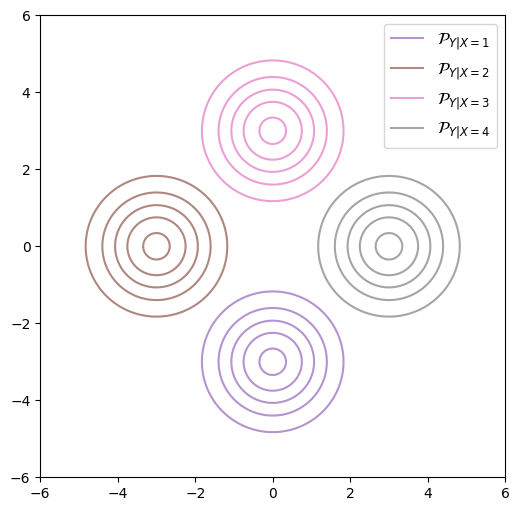

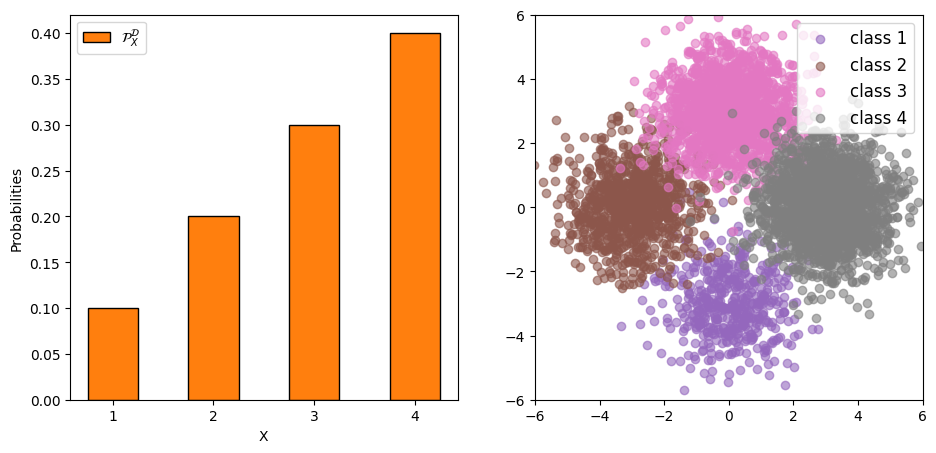

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.14it/s, acceptance = tensor(0.3100)]

torch.Size([4])


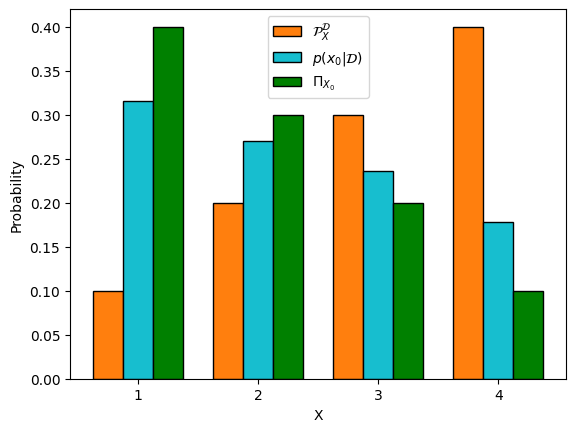

In [69]:
m = 0
inference_prior = torch.tensor([4,3,2,1])/10
r = np.arange(4)
dataset_prior = torch.tensor([1,2,3,4])/10

locations = m*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0])
    obs = torch.sum(mvn.sample(number_samples)*labels.unsqueeze(-1), dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([5000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i+4))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

total_numbers = 5000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1", color='C' +str(4))
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2", color='C' +str(5))
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3", color='C' +str(6))
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4", color='C' +str(7))
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None,100)
samples_beta_post = sampler.sample(500,tau = 7e-4)
with torch.no_grad():
    list_log_prob = torch.mean(torch.exp(model.log_prob(samples_obs,samples_beta_post)), dim =[0,1])
print(list_log_prob.shape)

prior_inference = torch.tensor([4,3,2,1])/10


r = np.arange(4) 
width = 0.25

plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'C9', 
        width = width, edgecolor = 'black', 
        label=r'$p(x_0|\mathcal{D})$') 
ax.bar(r+4*width, prior_inference, color = 'green', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 


ax.legend()
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 

plt.show() 

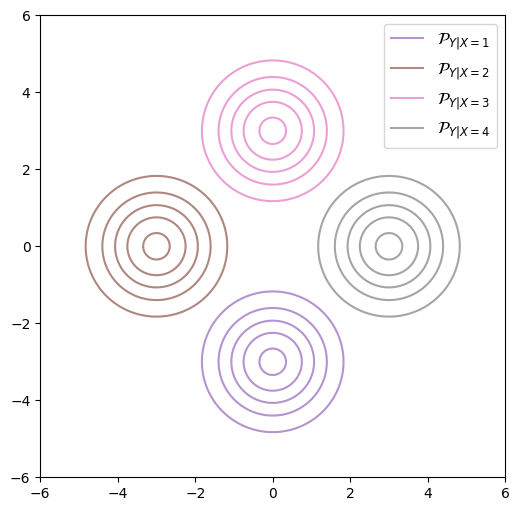

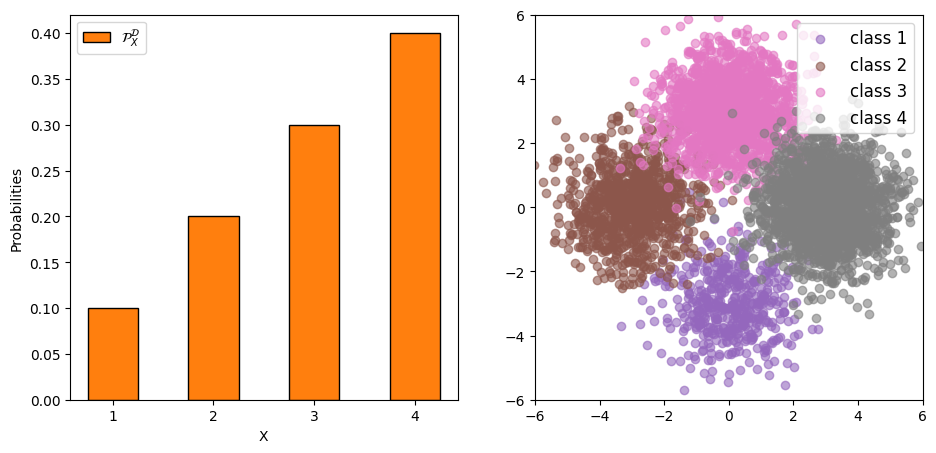

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.14it/s, acceptance = tensor(0.3100)]

torch.Size([4])


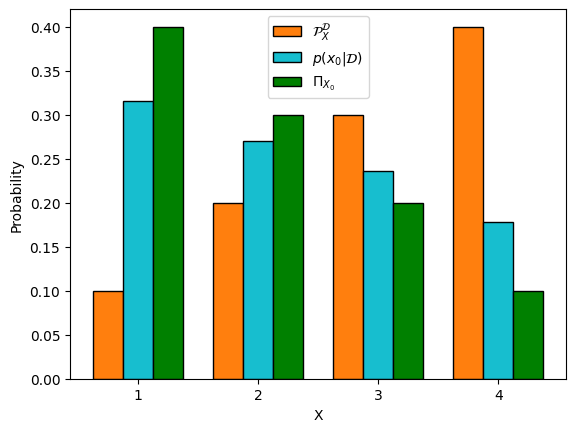

In [69]:
m = 3
inference_prior = torch.tensor([4,3,2,1])/10
r = np.arange(4)
dataset_prior = torch.tensor([1,2,3,4])/10

locations = m*torch.tensor([[0.,-1.],[-1.,0.],[0.,1.],[1.,0.]])
def sample_DGP(number_samples, prior):
    x = torch.distributions.Categorical(prior)
    mvn = torch.distributions.MultivariateNormal(locations, torch.eye(2).unsqueeze(0).repeat(locations.shape[0],1,1))
    labels  = torch.nn.functional.one_hot(x.sample(number_samples), num_classes = prior.shape[0])
    obs = torch.sum(mvn.sample(number_samples)*labels.unsqueeze(-1), dim = 1)
    return obs, labels
samples_obs, labels_obs = sample_DGP([5000],inference_prior)

def plot_2d_contour(f,range = [[-10,10],[-10,10]], bins = [50,50],levels = 4, alpha = 0.7,show = True,color = None):
    with torch.no_grad():
        tt_x = torch.linspace(range[0][0], range[0][1], bins[0])
        tt_y = torch.linspace(range[1][0],range[1][1], bins[1])
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plot=plt.contour(tt_x,tt_y,f(mesh).numpy().reshape(bins[0],bins[1]).T,levels = levels, colors = color, alpha = alpha)
    if show:
        plt.show()
    return plot
plt.figure(figsize = (6,6))
plt.xlim([-6,6])
plt.ylim([-6,6])
list_handles = []
for i in range(4):
    distribution = torch.distributions.MultivariateNormal(locations[i], torch.eye(2))
    contour = plot_2d_contour(lambda x: torch.exp(distribution.log_prob(x)),bins = [200,200], range =[[-5,5],[-5,5]],levels = 5, show = False, color = 'C'+str(i+4))
    handles, labels = contour.legend_elements()
    list_handles.append(handles[0])
plt.legend(list_handles, [r'$\mathcal{P}_{Y|X=1}$',r'$\mathcal{P}_{Y|X=2}$',r'$\mathcal{P}_{Y|X=3}$',r'$\mathcal{P}_{Y|X=4}$'], ncol = 1, fontsize = 12, loc = 'upper right')
plt.show()

total_numbers = 5000
index = torch.distributions.Categorical(dataset_prior/torch.sum(dataset_prior)).sample([total_numbers])
number_samples= torch.sum(torch.nn.functional.one_hot(index), dim = 0)

fig = plt.figure(figsize = (11,5))
width = 0.5
ax1 = fig.add_subplot(121)
ax1.bar(range(4),(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax1.set_xticks(r,['1','2','3','4']) 
ax1.set_xlabel("X")
ax1.set_ylabel("Probabilities")
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.set_xlim([-6,6])
ax2.set_ylim([-6,6])
samples_0 = torch.randn(number_samples[0],2)+locations[0]
samples_1 = torch.randn(number_samples[1],2)+locations[1]
samples_2 = torch.randn(number_samples[2],2)+locations[2]
samples_3 = torch.randn(number_samples[3],2)+locations[3]
ax2.scatter(samples_0[:,0].numpy(),samples_0[:,1].numpy(), alpha = .6, label ="class 1", color='C' +str(4))
ax2.scatter(samples_1[:,0].numpy(),samples_1[:,1].numpy(), alpha = .6, label ="class 2", color='C' +str(5))
ax2.scatter(samples_2[:,0].numpy(),samples_2[:,1].numpy(), alpha = .6, label ="class 3", color='C' +str(6))
ax2.scatter(samples_3[:,0].numpy(),samples_3[:,1].numpy(), alpha = .6, label ="class 4", color='C' +str(7))
ax2.legend(ncol = 1, fontsize = 12,loc = 'upper right')

samples = torch.cat([samples_0, samples_1, samples_2, samples_3])
labels = torch.cat([torch.zeros(number_samples[0]), torch.ones(number_samples[1]), 2*torch.ones(number_samples[2]), 3*torch.ones(number_samples[3])]).long()
plt.show()
model = LogisticClassifier(samples, torch.nn.functional.one_hot(labels))
sampler = MetropolisAdjustedLangevin(lambda beta: model.log_posterior_prob(beta),model.sample_beta_from_prior([1]).shape[-1],None,100)
samples_beta_post = sampler.sample(500,tau = 7e-4)
with torch.no_grad():
    list_log_prob = torch.mean(torch.exp(model.log_prob(samples_obs,samples_beta_post)), dim =[0,1])
print(list_log_prob.shape)

prior_inference = torch.tensor([4,3,2,1])/10


r = np.arange(4) 
width = 0.25

plt.figure()
ax = plt.subplot(111)
ax.bar(r+2*width,(dataset_prior/torch.sum(dataset_prior)).numpy(),width = width, color = 'C1',edgecolor = 'black', label =r'$\mathcal{P}_X^{\mathcal{D}}$')
ax.set_xticks(r+3*width,['1','2','3','4']) 
ax.set_xlabel("X")
ax.set_ylabel("Probabilities")
ax.bar(r+3*width, list_log_prob, color = 'C9', 
        width = width, edgecolor = 'black', 
        label=r'$p(x_0|\mathcal{D})$') 
ax.bar(r+4*width, prior_inference, color = 'green', 
        width = width, edgecolor = 'black', 
        label=r'$\Pi_{X_0}$') 


ax.legend()
plt.xlabel("X") 
plt.ylabel("Probability") 

plt.legend() 

plt.show() 